# Computer Lab 2 SD-TSIA211: Digit recognition

*El arji Hamza*

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

11490434/11490434 [==============================] - 0s 0us/step
5


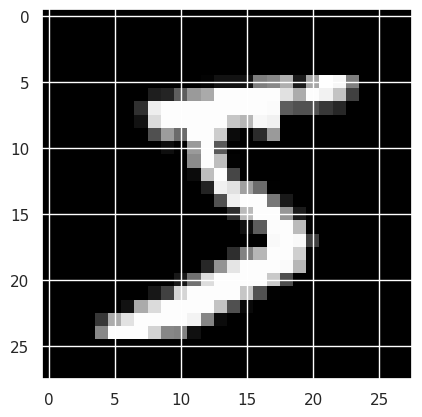

In [2]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]
print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

In [3]:
def init():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(32, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    return (model, loss)

def update_weights(model, update):
    new_weights = model.trainable_weights.copy()
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + update[i]
    model.set_weights(new_weights)

model, loss = init()
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 predictions (Dense)         (None, 10)                330       
                                                                 
Total params: 26506 (103.54 KB)
Trainable params: 26506 (103.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
# untrained model
logits = model(x_train)
np.argmax(logits, 1)[0:100]

# what we would like to get
y_train[0:100]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1], dtype=uint8)

In [5]:
## Computing a stochastic gradient

# Source: https://keras.io/guides/writing_a_training_loop_from_scratch/

# Example of gradient computation using automatic differentiation

model, loss = init()

x_train_batch = x_train[:8]
y_train_batch = y_train[:8]

with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
        logits = model(x_train_batch)  # Logits for this minibatch

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

## Evaluate model
samples_for_evaluation = np.random.randint(0, 10000, 1000)
logits = model(x_train[samples_for_evaluation])
loss(y_train[samples_for_evaluation], logits).numpy()

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2.3665895

**Question 4.1 How many optimization variables are we going to train using this model?**


The optimization variables in a neural network typically consist of the weights and biases for each layer. The model described in the image has three Dense layers, each with its own set of weights and biases. Let's calculate the number of optimization variables (parameters) for each layer:

### Input Layer to `dense_1` Layer:
- **Weights**: Each of the 784 input features connects to 32 neurons, so there are \( 784 \times 32 \) weights.
- **Biases**: There is one bias term for each neuron, so there are 32 biases.

### `dense_1` Layer to `dense_2` Layer:
- **Weights**: Each of the 32 neurons from `dense_1` connects to 32 neurons in `dense_2`, so there are \( 32 \times 32 \) weights.
- **Biases**: Again, one bias per neuron in `dense_2` gives us 32 biases.

### `dense_2` Layer to `predictions` (Output) Layer:
- **Weights**: Each of the 32 neurons from `dense_2` connects to 10 output neurons, so there are \( 32 \times 10 \) weights.
- **Biases**: With 10 neurons in the output layer, there are 10 biases.

Now, let's add them up to get the total number of optimization variables:

- Weights between Input Layer and `dense_1`: \( 784 \times 32 = 25,088 \)
- Biases in `dense_1`: \( 32 \)
- Weights between `dense_1` and `dense_2`: \( 32 \times 32 = 1,024 \)
- Biases in `dense_2`: \( 32 \)
- Weights between `dense_2` and `predictions`: \( 32 \times 10 = 320 \)
- Biases in `predictions`: \( 10 \)

Adding these together:

**Total optimization variables**: \( 25,088 + 32 + 1,024 + 32 + 320 + 10 = 26,506 \)

So, the model has 26,506 optimization variables (parameters) that will be trained.


## Stochastic gradient descent :

**Q5.1 :Reusing the code provided in the basic functions file, implement stochastic gradient descent for the resolution of the neural network model.**

In [7]:
def init():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(32, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    return (model, loss)

def update_weights(model, update):
    new_weights = model.trainable_weights.copy()
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + update[i]
    model.set_weights(new_weights)

def SGD(model, X, Y, loss, epochs=1, batch_size=1, gamma_0=0.01, print_batch=True):  # Adjusted gamma_0 to 0.01
    steps, losses = [], []

    for epoch in range(epochs):
        print(f"---------- EPOCH {epoch+1} ----------")

        train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

        gamma = gamma_0
        steps_bis, losses_bis = [], []
        for step, (X_batch, Y_batch) in enumerate(train_dataset):
            # Adjust to record more frequently, e.g., every 10 steps
            if step % 10 == 0:  # Changed from 200 to 10
                loss_value = loss(Y_batch, model(X_batch, training=True)).numpy()
                steps_bis.append(step)
                losses_bis.append(loss_value)
                if print_batch:
                    print(f"Training loss (for one batch) at step {step}: {loss_value}")

            with tf.GradientTape() as tape:
                logits = model(X_batch, training=True)
                loss_value = loss(Y_batch, logits)

            grad = tape.gradient(loss_value, model.trainable_weights)
            update = [tf.math.scalar_mul(-gamma, t) for t in grad]
            update_weights(model, update)

            gamma = gamma_0 / np.sqrt(step + 1)  # Learning rate adjustment

        steps.append(steps_bis)
        losses.append(losses_bis)

    return steps, losses


**Q5.2 :Run it for one pass over the data (also called one epoch) and with a learning rate that satisfies the conditions required by theory**


In [8]:
%%time
model, loss = init()
steps_bis, losses_bis = SGD(model, x_train, y_train, loss, epochs=10, batch_size=32, print_batch=False)

---------- EPOCH 1 ----------
---------- EPOCH 2 ----------
---------- EPOCH 3 ----------
---------- EPOCH 4 ----------
---------- EPOCH 5 ----------
---------- EPOCH 6 ----------
---------- EPOCH 7 ----------
---------- EPOCH 8 ----------
---------- EPOCH 9 ----------
---------- EPOCH 10 ----------
CPU times: user 3min 41s, sys: 6.36 s, total: 3min 47s
Wall time: 5min 3s


---------- EPOCH 1 ----------


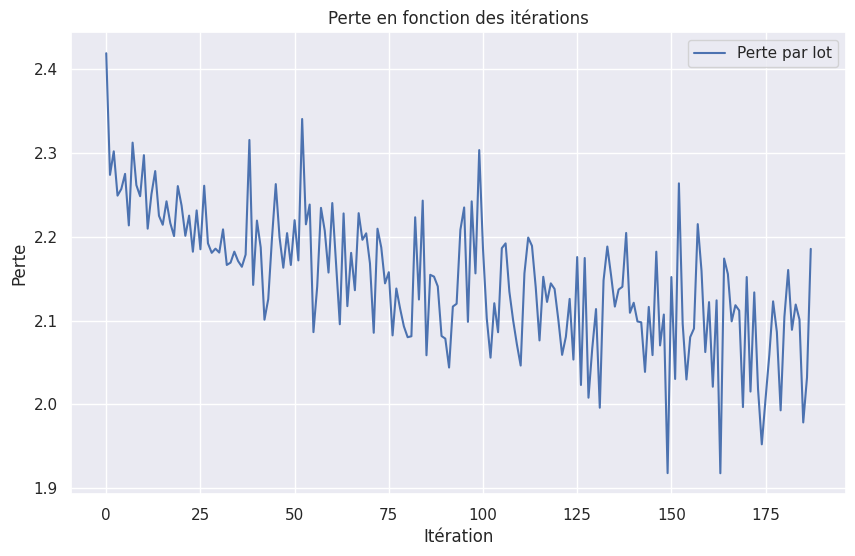

CPU times: user 23.5 s, sys: 897 ms, total: 24.4 s
Wall time: 26.3 s


In [9]:
%%time
# Initialize the model and loss function
model, loss = init()

# Run SGD for one epoch
steps, losses = SGD(model, x_train, y_train, loss, epochs=1, batch_size=32, gamma_0 = 0.01, print_batch=False)

plt.figure(figsize=(10, 6))
for epoch_losses in losses:
    plt.plot(epoch_losses, label='Perte par lot')
plt.title('Perte en fonction des itérations')
plt.xlabel('Itération')
plt.ylabel('Perte')
plt.legend()
plt.show()



## Empirical risk minimization :

**Question 6.1 : Implement stochastic gradient descent for the resolution of the empirical risk minimization problem and run it for 10 epochs.**

---------- EPOCH 1 ----------
---------- EPOCH 2 ----------
---------- EPOCH 3 ----------
---------- EPOCH 4 ----------
---------- EPOCH 5 ----------
---------- EPOCH 6 ----------
---------- EPOCH 7 ----------
---------- EPOCH 8 ----------
---------- EPOCH 9 ----------
---------- EPOCH 10 ----------


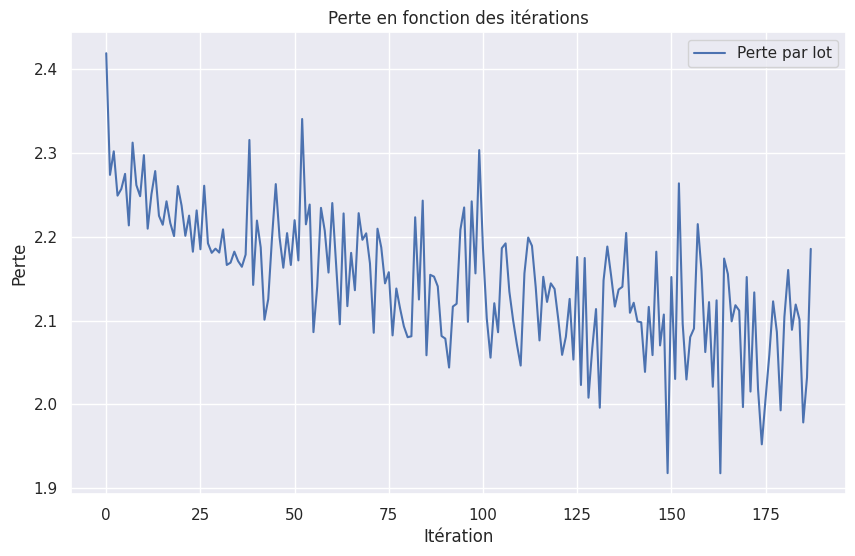

In [10]:
# Initialize the model and loss function
model, loss = init()

# Run SGD for 10 epochs
steps_bis, losses_bis = SGD(model, x_train, y_train, loss, epochs=10, batch_size=32, gamma_0=0.01, print_batch=False)

plt.figure(figsize=(10, 6))
for epoch_losses in losses:
    plt.plot(epoch_losses, label='Perte par lot')
plt.title('Perte en fonction des itérations')
plt.xlabel('Itération')
plt.ylabel('Perte')
plt.legend()
plt.show()

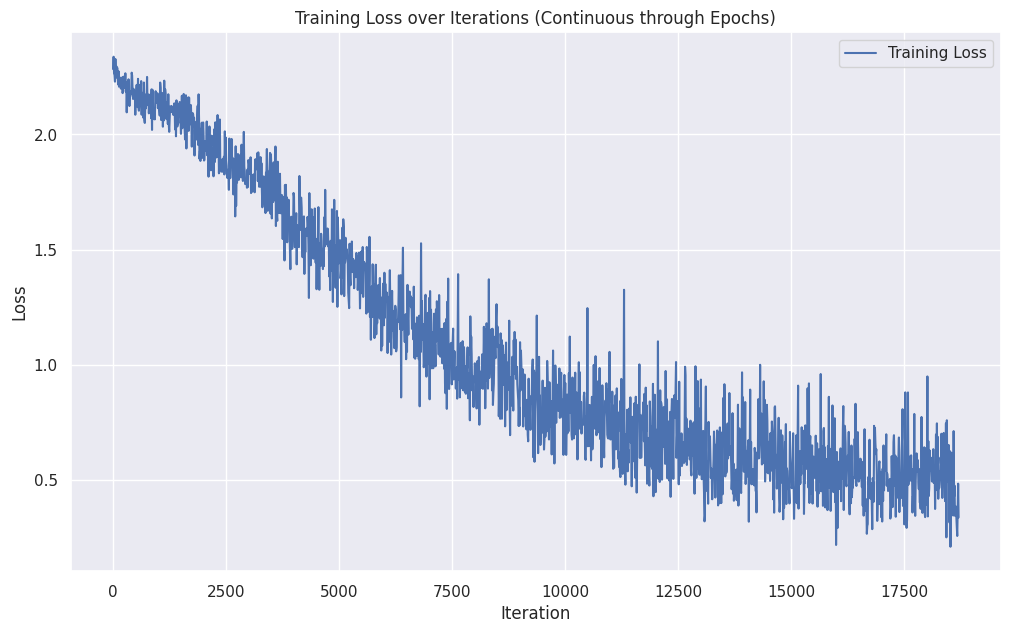

In [11]:
adjusted_steps = []
current_step = 0  # This will keep track of the cumulative step count

# Adjust the steps for each epoch
for epoch_steps in steps_bis:
    adjusted_epoch_steps = [current_step + step for step in epoch_steps]
    adjusted_steps.extend(adjusted_epoch_steps)
    current_step = adjusted_epoch_steps[-1]  # Update the current step count

# Flatten the losses list (which is a list of lists, one sublist per epoch)
flattened_losses = [loss for epoch_losses in losses_bis for loss in epoch_losses]

# Plot the objective value as a function of the iterations
plt.figure(figsize=(12, 7))
plt.plot(adjusted_steps, flattened_losses, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations (Continuous through Epochs)')
plt.legend()
plt.grid(True)
plt.show()

**Question  6.2 : According to you, what is the advantage of such a scheme?**

By averaging the gradient over a batch of samples, the variance of the updates is reduced compared to pure SGD (where each update is based on a single sample). This often leads to more stable and reliable convergence patterns.

##  Evaluation of the model :

In [14]:
x_train, y_train = train_data
x_test, y_test = test_data

# Function to evaluate the model accuracy
def evaluate_model(model, x_data, y_data):
    x_data_flat = x_data.reshape(x_data.shape[0], -1)
    predictions = model.predict(x_data_flat)
    predicted_classes = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_classes == y_data)
    return accuracy

# Evaluate on training set
train_accuracy = evaluate_model(model, x_train, y_train)
print(f"Accuracy on training set: {train_accuracy * 100:.2f}%")

# Evaluate on test set
test_accuracy = evaluate_model(model, x_test, y_test)
print(f"Accuracy on test set: {test_accuracy * 100:.2f}%")


1875/1875 [==============================] - 3s 2ms/step
Accuracy on training set: 86.54%
313/313 [==============================] - 1s 2ms/step
Accuracy on test set: 86.90%
